In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks"

 BVP.ipynb		     lenet.ipynb
 Cholesky.ipynb		     linear-regression-scratch.ipynb
'Copy of bysection.ipynb'    Object_Oriented_Programming_Basics.ipynb
'Copy of fixedpoint.ipynb'   SVD.ipynb
'Copy of Newton.ipynb'	     Untitled0.ipynb
 GAN_MNIST_Data.ipynb	     VAE_DeepLearning.ipynb
 HW6_VAE.ipynb		     weight-decay.ipynb
 kaggle-house-price.ipynb


In [3]:
#Importing data
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 166731678.86it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42895075.72it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 132511187.69it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15796458.35it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
#Note that pixel values were transformed from the range [0, 1] to the range [-1, 1].
#Look at sample tensor values.
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [5]:
img.size(dim=1)

28

In [6]:
img.size()

torch.Size([1, 28, 28])

In [7]:
# function to denormalize and view the images. 
# This function will also be useful for viewing the generated images.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


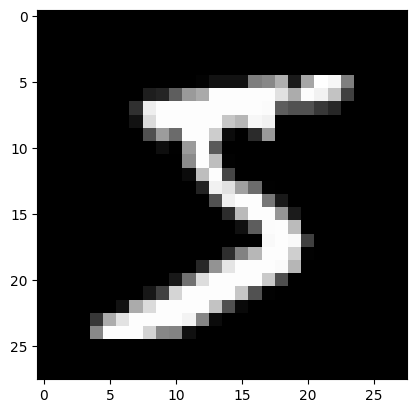

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [9]:
#Create a dataloader to load the images in batches.
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 5, 4, 0, 4, 3, 2, 8, 2, 6, 2, 9, 3, 7, 2, 8, 4, 2, 9, 3, 8, 3, 9, 6,
        3, 7, 6, 1, 3, 4, 0, 8, 7, 1, 0, 0, 4, 9, 3, 2, 6, 1, 1, 4, 2, 0, 5, 3,
        6, 1, 5, 3, 3, 7, 4, 2, 6, 3, 7, 1, 9, 5, 4, 5, 2, 6, 3, 4, 4, 0, 7, 2,
        1, 2, 4, 3, 1, 7, 5, 3, 3, 6, 5, 0, 3, 2, 9, 2, 8, 1, 9, 3, 3, 4, 9, 4,
        0, 5, 8, 7])


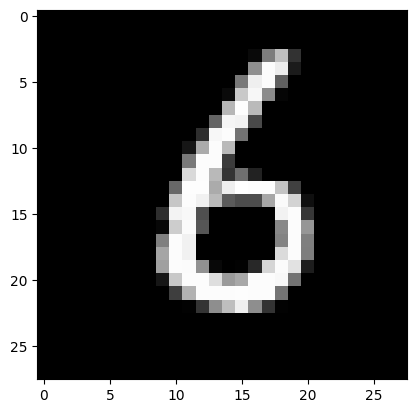

In [10]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
#Discriminator Network
image_size = 784
hidden_size = 256

In [13]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [14]:
# Move the discriminator model to the chosen device.
D.to(device);

In [15]:
# Genarator Network
latent_size = 128

In [16]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [17]:
G.to(device);

# Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated. 

We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0. 

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (d_optimizer only affects the D.parameters())


In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score



# Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.


In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images


# Training the Model

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model.


In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)



Let's save a batch of real images that we can use for visual comparision while looking at the generated images.


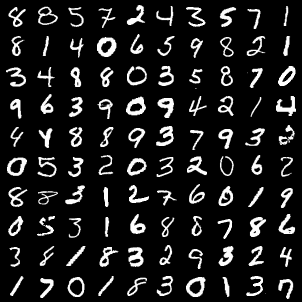

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

 We can save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


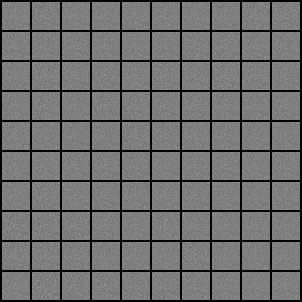

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


# Training the GAN. 

In each epoch, we train the discriminator first, and then the generator. 

In [25]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.2667, g_loss: 2.5032, D(x): 0.93, D(G(z)): 0.12
Epoch [0/300], Step [400/600], d_loss: 0.0294, g_loss: 7.6793, D(x): 0.98, D(G(z)): 0.01
Epoch [0/300], Step [600/600], d_loss: 0.3394, g_loss: 8.9838, D(x): 0.97, D(G(z)): 0.24
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0446, g_loss: 7.0647, D(x): 1.00, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.2789, g_loss: 5.2584, D(x): 0.91, D(G(z)): 0.08
Epoch [1/300], Step [600/600], d_loss: 1.2887, g_loss: 2.4315, D(x): 0.75, D(G(z)): 0.48
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1331, g_loss: 3.2876, D(x): 0.95, D(G(z)): 0.06
Epoch [2/300], Step [400/600], d_loss: 0.9385, g_loss: 1.5639, D(x): 0.76, D(G(z)): 0.37
Epoch [2/300], Step [600/600], d_loss: 0.2461, g_loss: 3.8685, D(x): 0.90, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.6693, g_loss: 1.9623, D(x): 0.64, D(G(z)): 0.26
Epoch [3/300], Step [400/6



Here's how the generated images look, after the 10th, 50th, 100th and 300th epochs of training.


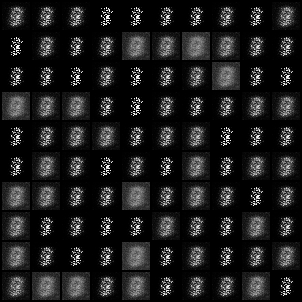

In [26]:
Image('./samples/fake_images-0010.png')

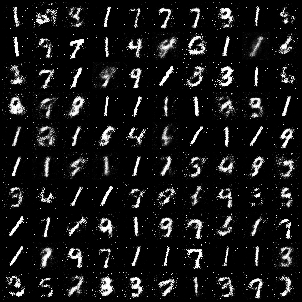

In [27]:
Image('./samples/fake_images-0050.png')

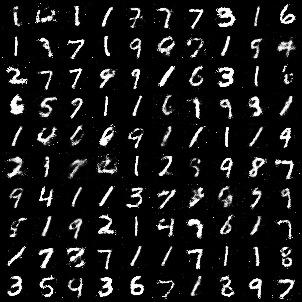

In [28]:
Image('./samples/fake_images-0100.png')

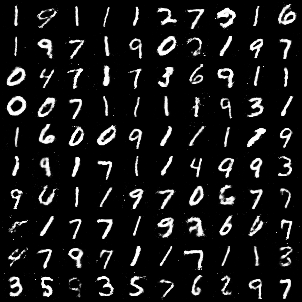

In [29]:
Image('./samples/fake_images-0300.png')

# Visualizing the Loss
we can see how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

Text(0.5, 1.0, 'Losses')

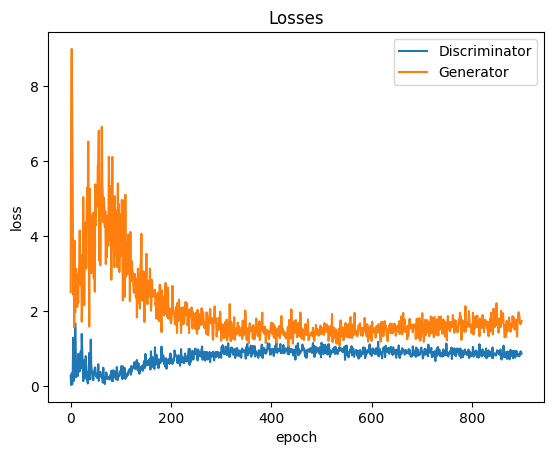

In [30]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')